<a href="https://colab.research.google.com/github/Eddiebee/AI-Craft/blob/main/A_Data_Analyst_Agent_Built_Cohere_and_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Data Analyst Agent Built with Cohere and LangChain



> Tool use is a method which allows developers to connect Cohere's Command models to external tools like search engines, APIs, databases, and other software tools. Just like how Retrieval-Augmented Generation (RAG) allows a model to use an external data source to improve factual generation, tool use is a capability that allows retrieving data from multiple sources. But it goes beyond simply retrieving information and is able to use software tools to execute code, or even create entries in a CRM system. _Cohere's Docs.


This notebook aims to apply the understanding from the reference docs by Cohere -- apply it to various use-cases with the simple aim of expressing proficiency and passion for LLM technology and build great stuff with them.

Leggo! 🚀



First off, we'll be creating a simple data analyst agent that is able to search the web and run code in a python interpreter. This agent uses Cohere's Command R+ model and LangChain.

We'll see how we can further enhance and extend this. Stay tuned!

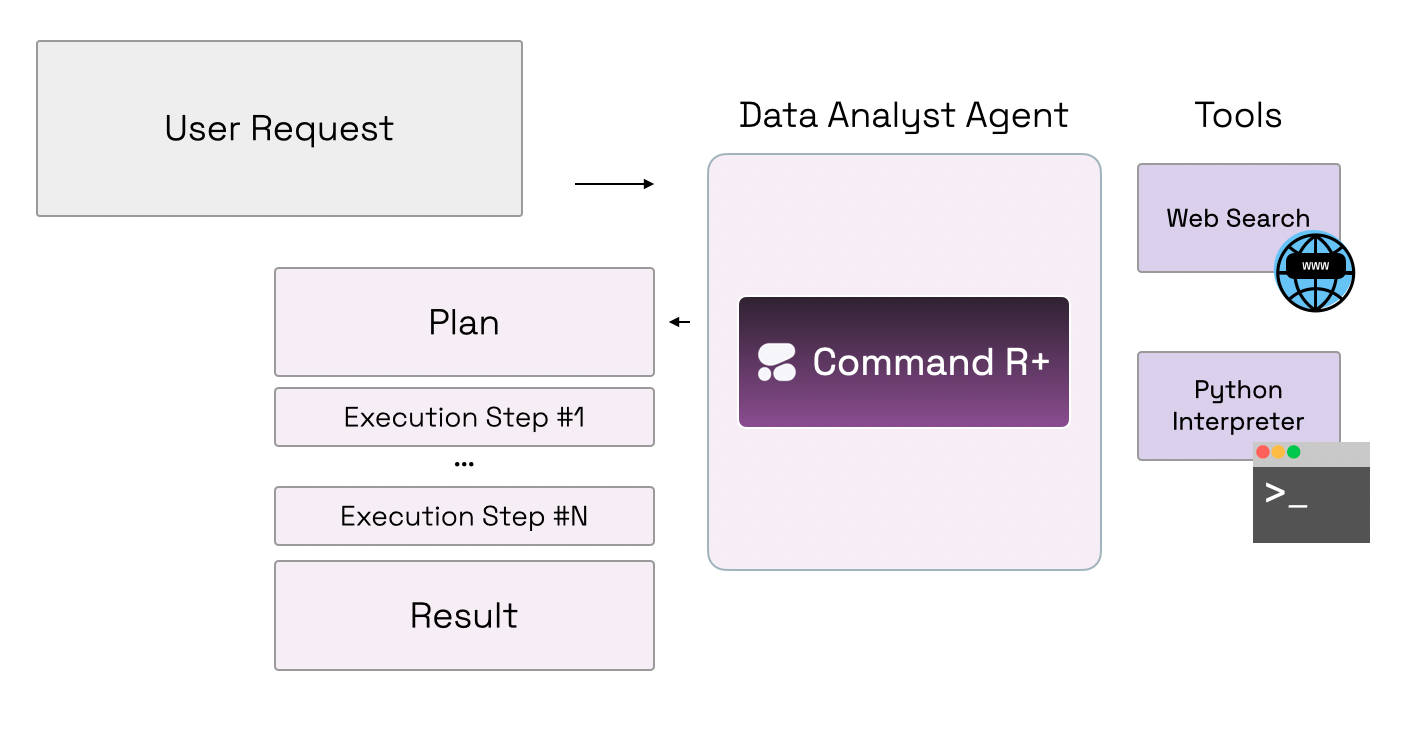

## Step 1: Installing the required libraries

In [1]:
!pip install --quiet langchain langchain_cohere langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.8/173.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

## Setup

We'll be needing a valid Cohere API Key and you can readily get one for trial [here](https://dashboard.cohere.ai/welcome/register). Simply register and then go ahead to create a new API key.

In [2]:
# Set up environment for interacting with Cohere models
import os
from google.colab import userdata

os.environ["COHERE_API_KEY"] = userdata.get('COHERE_TRIAL_KEY')

In [3]:
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0.3)

Our simple data analyst agent will be equipped with a web search tool, and a Python interpreter (which can be used to run plotting code, for example).

## Web Search: equipping our Data Analyst with Web Search capability 🕸

We can make use of the Tavily API for this. Simply head over to [tavily.com](https://tavily.com/) to get yours.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "A tool for searching the internet. \
                                Returns a list of relevant document snippets \
                                for a textual query retrieved from the internet."


from langchain_core.pydantic_v1 import BaseModel, Field
class TavilySearchInput(BaseModel):
  query: str = Field(description="Query to search the internet with.")

internet_search.args_schema = TavilySearchInput

## Python Interpreter: equipping our Data Analyst agent with a Python Interpreter

In [5]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
python_repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. \
    The code runs in a static sandbox without interactive mode, \
    so print output or save output to a file.",
    func=python_repl.run,
)

python_repl_tool.name = "python_interpreter"

class ToolInput(BaseModel):
  code: str = Field(description="Python code to execute.")

python_repl_tool.args_schema = ToolInput

## Define our Data Analyst Agent

In [6]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [8]:
prompt = ChatPromptTemplate.from_template("{input}")

agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, python_repl_tool],
    prompt=prompt,
)

In [9]:
agent_executor = AgentExecutor(
    agent=agent,
    tools=[internet_search, python_repl_tool],
    verbose=True,
)

In [10]:
# Now we can invoke our Data Analyst Agent
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the \
    3 tech companies with the highest market cap in the United States in 2024.",
})



> Entering new AgentExecutor chain...

First, I will search for the 3 tech companies with the highest market cap in the United States in 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'internet_search', 'parameters': {'query': '3 tech companies with highest market cap in the United States in 2024'}}
[{'url': 'https://www.financecharts.com/screener/biggest-country-us', 'content': 'Research the largest companies in the US by market cap for Jun 2024. 100% free, 20 years of data! ... Biggest Companies in the US by Market Cap for Jun 2024. The most valuable company in the US is Microsoft ... Information Technology: $3.335T: $213.25 +2%: $381.623B: $100.389B: 15.71%: 60.93%: 0.47%: 3: NVIDIA: NVDA: US: Information Technology:'}, {'url': 'https://disfold.com/united-states/sector/technology/companies/', 'content': 'Unlock Financial AI

{'input': 'Create a plot of the number of full time employees at the     3 tech companies with the highest market cap in the United States in 2024.',
 'output': "Here is a plot of the number of full-time employees at the 3 tech companies with the highest market cap in the United States in 2024:\n\n![Number of Full-Time Employees at Top 3 Tech Companies in the US in 2024]('number_of_full_time_employees_at_top_3_tech_companies_in_the_US_in_2024.png')\n\nThe 3 tech companies with the highest market cap in the United States in 2024 are Apple, Microsoft, and Nvidia. As of January 2024, Apple had 164,000 full-time employees, Microsoft had 221,000 full-time employees, and Nvidia had 29,600 full-time employees.",
 'citations': [CohereCitation(start=372, end=377, text='Apple', documents=[{'url': 'https://www.financecharts.com/screener/biggest-country-us', 'content': 'Research the largest companies in the US by market cap for Jun 2024. 100% free, 20 years of data! ... Biggest Companies in the US

In [11]:
# I didn't get the visual plot as output, how do I go around this?
response = agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the \
    3 tech companies with the highest market cap in the United States in 2024.",
})



> Entering new AgentExecutor chain...

First, I will search for the 3 tech companies with the highest market cap in the United States in 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at each company.
{'tool_name': 'internet_search', 'parameters': {'query': '3 tech companies with the highest market cap in the United States in 2024'}}
[{'url': 'https://www.financecharts.com/screener/biggest-country-us', 'content': 'Research the largest companies in the US by market cap for Jun 2024. 100% free, 20 years of data! ... Biggest Companies in the US by Market Cap for Jun 2024. The most valuable company in the US is Microsoft (MSFT) ... Information Technology: $3.335T: $213.25 +2%: $381.623B: $100.389B: 15.71%: 60.93%: 0.47%: 3: NVIDIA: NVDA: US: Information ...'}, {'url': 'https://disfold.com/united-states/sector/technology/companies/', 'content': 'Unlock Financial AI

In [17]:
response.get("output").split(":")[1]

"\n\n! [Number of Full-Time Employees at Tech Companies with Highest Market Cap in the US in 2024]('number_of_full_time_employees_at_tech_companies.png')\n\nThe 3 tech companies with the highest market cap in the United States in 2024 are Microsoft, Apple, and Nvidia. As of June 30, 2023, Microsoft employed approximately 221,000 people on a full-time basis. Apple had 161,000 employees on September 30, 2023. Nvidia had 29,600 employees on January 28, 2024."

Attempt to plot the data gotten from our Data Analyst Agent using Matplotlib:

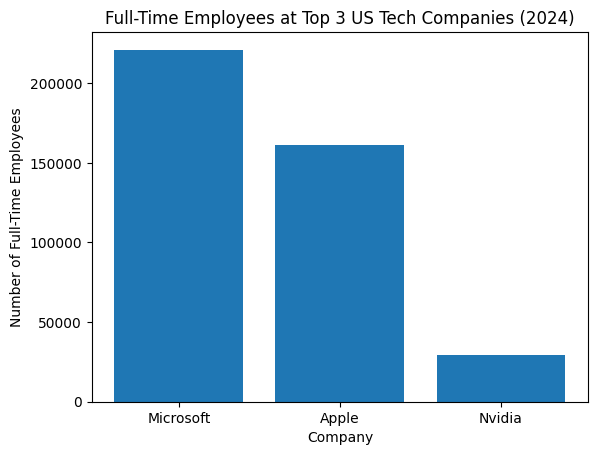

In [18]:
import matplotlib.pyplot as plt

# Data (using a list of tuples)
data = [('Microsoft', 221000), ('Apple', 161000), ('Nvidia', 29600)]

# Extract company names and employee counts
companies = [company for company, _ in data]
employees = [count for _, count in data]

# Create the bar chart
plt.bar(companies, employees)

# Add labels and title
plt.xlabel('Company')
plt.ylabel('Number of Full-Time Employees')
plt.title('Full-Time Employees at Top 3 US Tech Companies (2024)')

# Display the plot
plt.show()

In [19]:
agent_executor.invoke({
    "input": "Howfar! how are you?",
})



> Entering new AgentExecutor chain...

I will respond to the user's greeting.
{'tool_name': 'directly_answer', 'parameters': {}}
directly_answer is not a valid tool, try one of [internet_search, python_interpreter].Relevant Documents: None
Cited Documents: None
Answer: Hello! I'm an AI assistant, so I don't have feelings, but I'm here to help you with your queries. How can I assist you today?
Grounded answer: Hello! I'm an AI assistant, so I don't have feelings, but I'm here to help you with your queries. How can I assist you today?

> Finished chain.


{'input': 'Howfar! how are you?',
 'output': "Hello! I'm an AI assistant, so I don't have feelings, but I'm here to help you with your queries. How can I assist you today?",
 'citations': []}

In [20]:
agent_executor.invoke({
    "input": "How you dey?",
})



> Entering new AgentExecutor chain...

I will answer the user's question directly.
{'tool_name': 'directly_answer', 'parameters': {}}
directly_answer is not a valid tool, try one of [internet_search, python_interpreter].Relevant Documents: None
Cited Documents: None
Answer: I'm sorry, I don't understand your question. Can you please clarify?
Grounded answer: I'm sorry, I don't understand your question. Can you please clarify?

> Finished chain.


{'input': 'How you dey?',
 'output': "I'm sorry, I don't understand your question. Can you please clarify?",
 'citations': []}

In [21]:
agent_executor.invoke({
    "input": "Howfar?",
})



> Entering new AgentExecutor chain...

I will ask the user what they mean by their query.
{'tool_name': 'directly_answer', 'parameters': {}}
directly_answer is not a valid tool, try one of [internet_search, python_interpreter].Relevant Documents: None
Cited Documents: None
Answer: Sorry, I don't understand your question. Can you explain what you mean?
Grounded answer: Sorry, I don't understand your question. Can you explain what you mean?

> Finished chain.


{'input': 'Howfar?',
 'output': "Sorry, I don't understand your question. Can you explain what you mean?",
 'citations': []}

Attempt another visualization: but this is by ChatGPT.

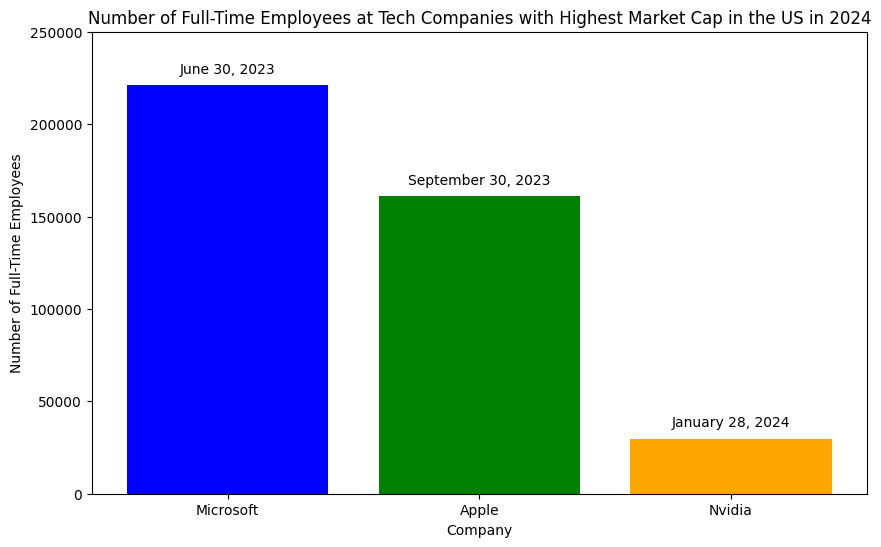

In [22]:
import matplotlib.pyplot as plt

# Data
companies = ['Microsoft', 'Apple', 'Nvidia']
employees = [221000, 161000, 29600]
dates = ['June 30, 2023', 'September 30, 2023', 'January 28, 2024']

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(companies, employees, color=['blue', 'green', 'orange'])

# Add title and labels
plt.title('Number of Full-Time Employees at Tech Companies with Highest Market Cap in the US in 2024')
plt.xlabel('Company')
plt.ylabel('Number of Full-Time Employees')
plt.ylim(0, 250000)

# Annotate bars with dates
for i, date in enumerate(dates):
    plt.text(i, employees[i] + 5000, date, ha='center', va='bottom')

# Save the plot
plt.savefig('number_of_full_time_employees_at_tech_companies.png')

# Show the plot
plt.show()
